# AI FOR SECURITY - PROJECT 2024/2025

## INTRODUCTION

The Internet of Medical Things (IoMT) has become increasingly vital in healthcare, enabling continuous patient monitoring and automated medical services. However, this connectivity also introduces cybersecurity risks that could compromise patient care and privacy. The CICIoMT2024 dataset, developed by the Canadian Institute for Cybersecurity (CIC), provides a comprehensive benchmark for evaluating IoMT security solutions.

### Dataset Overview
- Contains network traffic from 40 IoMT devices (25 real and 15 simulated)
- Includes traffic across multiple protocols: Wi-Fi, MQTT, and Bluetooth
- Features 18 different types of attacks categorized into:
  - DDoS (Distributed Denial of Service)
  - DoS (Denial of Service)
  - Reconnaissance
  - MQTT-specific attacks
  - Spoofing


### Project Objectives
1. Analyze a subset of the CICIoMT2024 dataset to develop efficient security models
2. Implement and evaluate both supervised and unsupervised learning approaches
3. Compare model performance across different attack categories
4. Identify the most effective model for real-time threat detection in IoMT networks

Our analysis will focus on the trade-off between model complexity and detection accuracy, aiming to provide practical insights for securing healthcare IoT infrastructure.

## Libraries

### Data Manipulation and Analysis

In [1]:
import pandas as pd
import numpy as np

### Data Visualisation

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm

### Text Processing

In [9]:
import re

### Machine Learning

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

### Evaluation

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### System/File Operations

In [11]:
import os
from typing import Tuple, Dict
from collections import defaultdict

## DATASET PREPARATION

### Download Dataset

Create the directory and download the whole CSV dataset through *wget*
```bash
mkdir dataset
cd dataset/ && wget -c -r -np -nH --cut-dirs=3 -R "index.html*" http://205.174.165.80/IOTDataset/CICIoMT2024/Dataset/WiFI_and_MQTT/attacks/CSV/
```

### Analyse Dataset

The dataset consists of network traffic files organized by protocols and different attack types. Due to the diverse distribution of data across files, our first step was to analyze the volume of samples. This initial assessment was crucial as significant imbalances in data volume between attack types or protocols could skew our analysis.

Understanding these distributions allowed us to create a balanced and representative subset of the data for our analysis while ensuring computational efficiency.

#### File Length Analysis

The following code analyzes and visualizes the data distribution across files, implementing our sampling process based on file sizes:

- Files < 20k rows: Retained entirely
- Files 20k-100k rows: Keep 20k rows + 20% of remaining data
- Files > 100k rows: Apply previous rules + 10% of remaining data

This stratified sampling approach helps maintain dataset balance while managing computational resources. The visualization uses color coding (green/orange/red) to highlight these size thresholds.

In [13]:
def get_color_by_length(length):
    if length < 20000:
        return 'green'
    elif length < 100000:
        return 'orange'
    else:
        return 'red'

def plot_len(name: str, directory_type: str = "original")->None:
    """
    Functions to analyze and visualize the distribution of data across files in the dataset:

    get_color_by_length(): Assigns colors based on file size (green: <20k rows, orange: 20k-100k rows, red: >100k rows)

    plot_len(): Creates bar plots showing the number of rows in each CSV file within a directory.
    Parameters:
    - name: Dataset name ('mqtt' or 'wifi')  
    - directory_type: Source directory ('original' or 'subset')

    compare_directories(): Compares data distributions between original and subset directories for a given protocol
    """
    # Base directory selection
    if directory_type.lower() == "original":
        base_dir = 'dataset/original'
        dir_suffix = "_og"
    elif directory_type.lower() == "subset":
        base_dir = 'dataset/subset'
        dir_suffix = ""
    else:
        raise ValueError("directory_type must be either 'original' or 'subset'")
    
    # Construct directory path
    data_dir = os.path.join(base_dir, name + dir_suffix)
    
    # Check if directory exists
    if not os.path.exists(data_dir):
        print(f"Directory not found: {data_dir}")
        return
    
    files = os.listdir(data_dir)
    
    # Dictionary to store file names and their lengths
    file_lengths = {}
    
    # Get length of each CSV file
    for file in tqdm(files, desc="Processing files"):
        if file.endswith('.csv'):
            file_path = os.path.join(data_dir, file)
            df = pd.read_csv(file_path)
            length = len(df)
            file_lengths[file] = length
 
    if not file_lengths:
        print(f"No CSV files found in {data_dir}")
        return
    
    # Create a bar plot
    plt.figure(figsize=(15, 8))
    
    # Create bars with colors based on length
    bars = plt.bar(file_lengths.keys(), file_lengths.values())
    
    # Set color for each bar based on its height
    if directory_type.lower() == "original":
        for bar in bars:
            bar.set_color(get_color_by_length(bar.get_height()))
    
    # Customize the plot
    plt.title(f'Number of Rows in Each CSV File - {name} Dataset ({directory_type})', pad=20)
    plt.xlabel('File Names')
    plt.ylabel('Number of Rows')
    
    # Add legend
    if directory_type.lower() == "original":
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor='green', label='<20k rows'),
                            plt.Rectangle((0,0),1,1, facecolor='orange', label='20k-100k rows'),
                            plt.Rectangle((0,0),1,1, facecolor='red', label='>100k rows')]
        plt.legend(handles=legend_elements)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'img/file_lengths_{name}_{directory_type}.png', bbox_inches='tight')
    #print(f"\nPlot saved as file_lengths_{name}_{directory_type}.png")
    
    # Display the plot
    plt.show()

def compare_directories(name: str)->None:
    print(f"\nAnalyzing {name} dataset in both original and subset directories...")
    plot_len(name, "original")
    plot_len(name, "subset")


Processing files: 100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


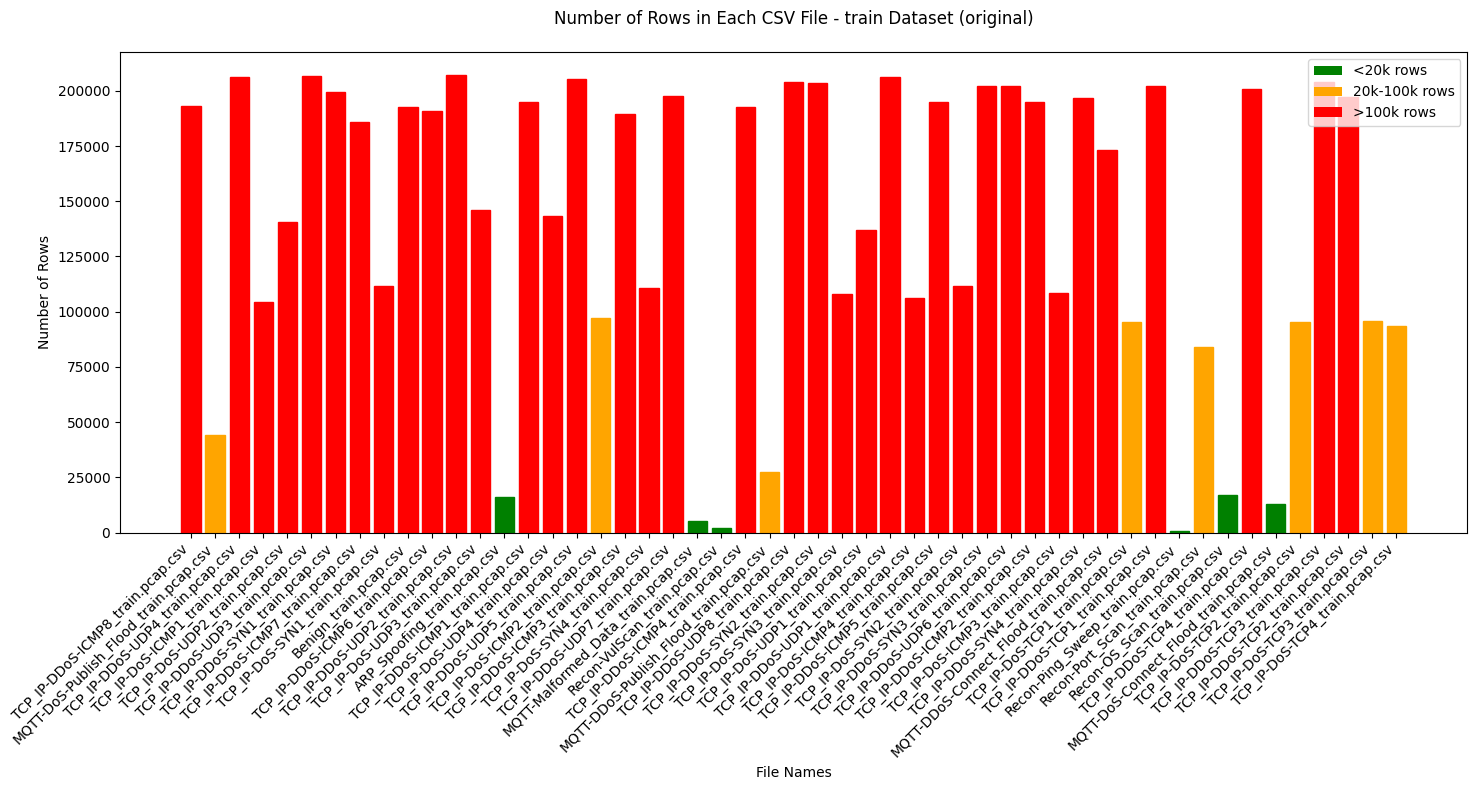

Processing files: 100%|██████████| 21/21 [00:09<00:00,  2.32it/s]


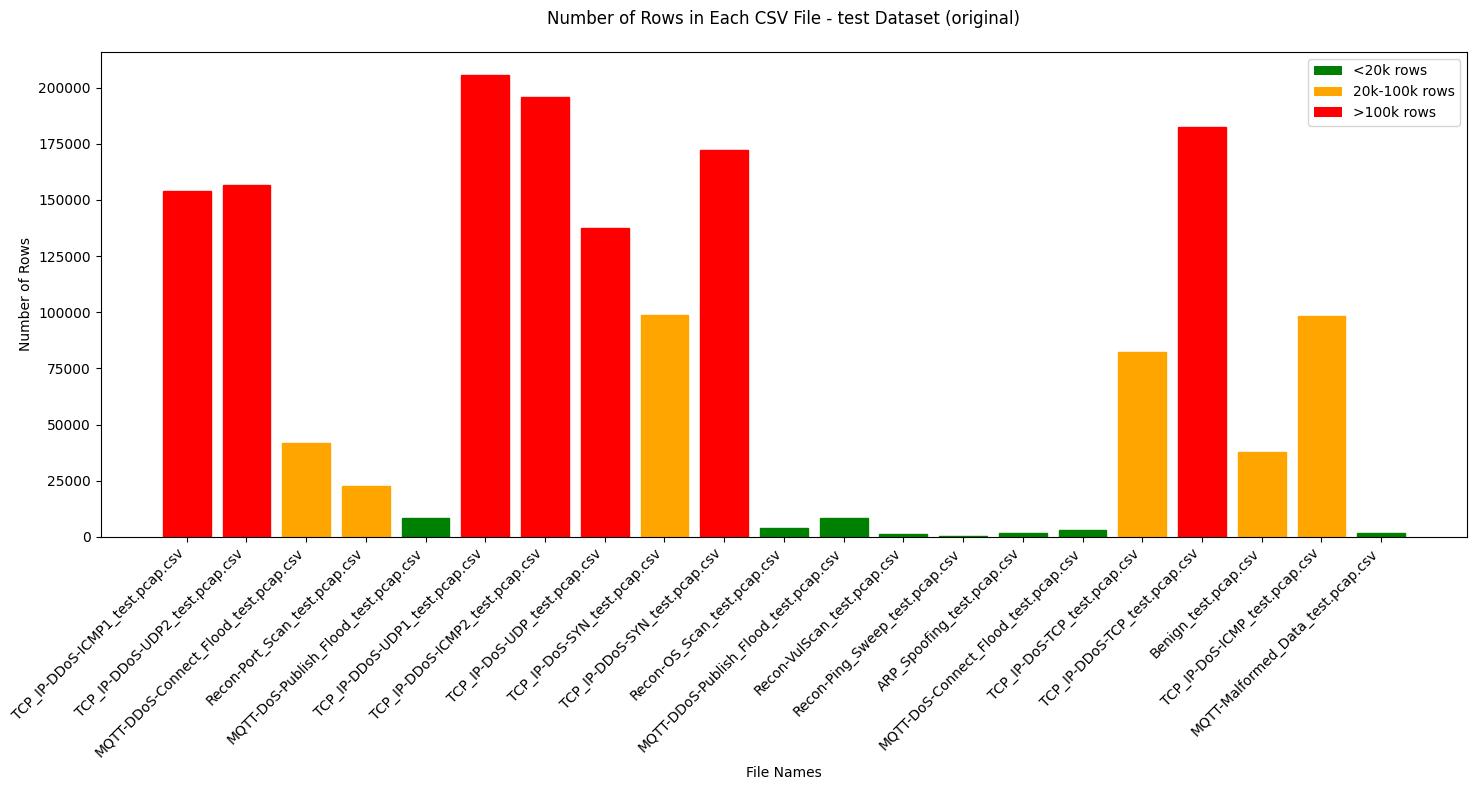

In [14]:
plot_len("train", "original")
plot_len("test", "original")

### Subset

#### Create Directory
```bash
mkdir dataset/subset && cd dataset/subset
mkdir train && mkdir test
```

#### Subset Generation 

This code implements our sampling strategy through random sampling, using a fixed random seed for reproducibility. 

For each file, it applies the rules presented before.
The stratified approach maintains data representativeness while reducing volume, with random sampling ensuring unbiased selection across each range.

In [15]:
RANDOM_SEED = 42

CAP = 20000
FIRST = 0.2
SECOND = 0.1

# List all files in the original dataset directory
original_dir = 'dataset/original'
subset_dir = 'dataset/subset'

def calculate_subset(df: pd.DataFrame) -> pd.DataFrame:
    total_rows = len(df)
    
    if total_rows < CAP:
        # For files under 20k rows, keep all rows
        return df
    
    elif total_rows < 100000:
        # For files between 20k and 100k:
        # 1. First 20k random rows
        first = df.sample(n=CAP, random_state=RANDOM_SEED)
        
        # 2. 20% of remaining rows
        remaining_rows = df.drop(first.index)
        additional_rows = remaining_rows.sample(frac=FIRST, random_state=RANDOM_SEED)
        
        # Combine both samples
        return pd.concat([first, additional_rows])
    
    else:
        # For files over 100k:
        # 1. First 20k random rows
        first = df.sample(n=CAP, random_state=RANDOM_SEED)
        
        # 2. 20% of next 80k rows
        next_80k = df.drop(first.index).sample(n=(100000-CAP), random_state=RANDOM_SEED)
        twenty_percent_of_80k = next_80k.sample(frac=0.2, random_state=RANDOM_SEED)
        
        # 3. 10% of remaining rows (those above 100k)
        remaining_rows = df.drop(first.index).drop(next_80k.index)
        ten_percent_of_remaining = remaining_rows.sample(frac=0.1, random_state=RANDOM_SEED)
        
        # Combine all samples
        return pd.concat([first, twenty_percent_of_80k, ten_percent_of_remaining])

def subset(name: str)-> None:
    np.random.seed(RANDOM_SEED)
    og_dir = os.path.join(original_dir, name + "_og")
    sub_dir = os.path.join(subset_dir, name)
    
    # Print the directory being processed
    print(f"Processing directory: {og_dir}")
    
    # Make sure the output directory exists
    os.makedirs(sub_dir, exist_ok=True)
    
    # List of all files
    files = os.listdir(og_dir)
    
    for file in tqdm(files, desc="Processing files"):
        file_path = os.path.join(og_dir, file)
        if os.path.isfile(file_path) and file.endswith('.csv'):
            # Read the CSV file
            df = pd.read_csv(file_path)
            original_size = len(df)
            
            # Calculate subset based on size
            df_subset = calculate_subset(df)
            
            # Save the subset to the new directory
            subset_file_path = os.path.join(sub_dir, file)
            df_subset.to_csv(subset_file_path, index=False)
            
            print_processed_info = lambda file, original_size, subset_size: print(
                f"Processed {file}:\n"
                f"  Original size: {original_size:,} rows\n"
                f"  Subset size: {subset_size:,} rows\n"
                f"  Reduction: {((original_size - subset_size) / original_size * 100):.1f}%\n"
            )
            #print_processed_info(file, original_size, len(df_subset))
    
    print(f"Finished processing {name} directory\n")

# Process both train and test datasets
subset("train")
subset("test")

Processing directory: dataset/original/train_og


Processing files: 100%|██████████| 51/51 [01:53<00:00,  2.22s/it]


Finished processing train directory

Processing directory: dataset/original/test_og


Processing files: 100%|██████████| 21/21 [00:27<00:00,  1.32s/it]

Finished processing test directory



Processing files: 100%|██████████| 51/51 [00:13<00:00,  3.91it/s]


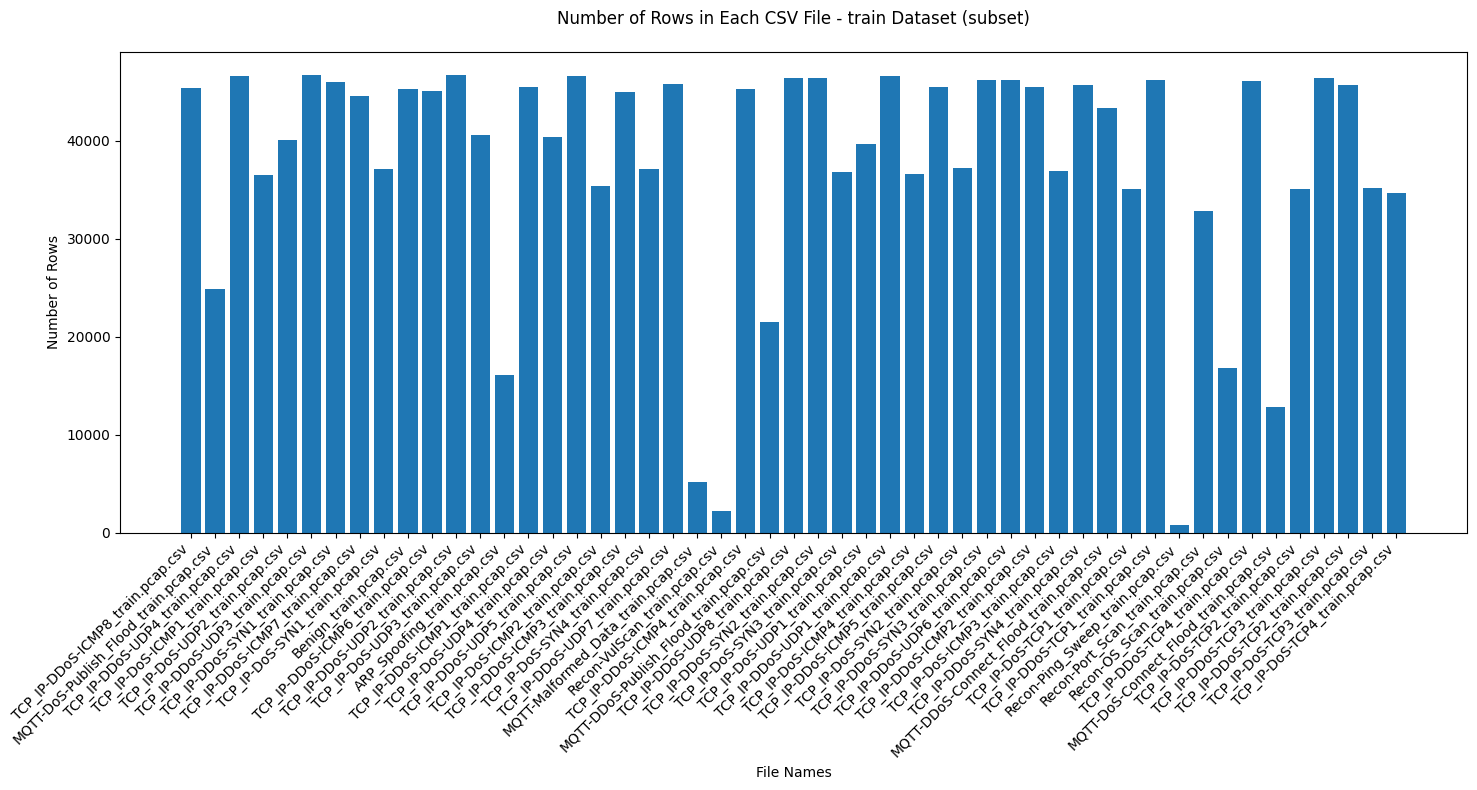

Processing files: 100%|██████████| 21/21 [00:04<00:00,  4.59it/s]


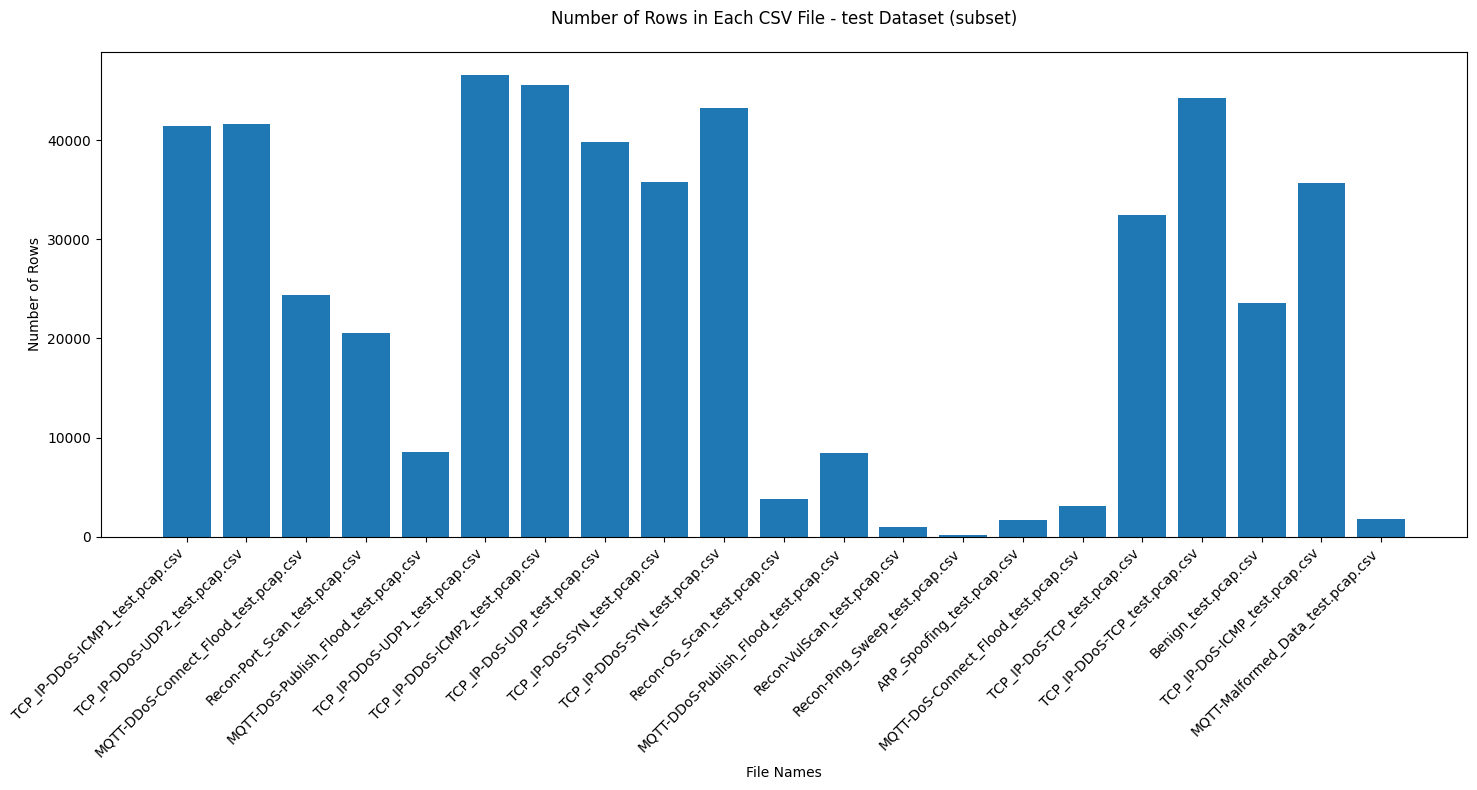

In [16]:
plot_len("train", "subset")
plot_len("test", "subset")

### Data Merging and Additional Feature Creation
After creating subsets, we merged the files into consolidated train and test datasets, adding two categorical features:
- `category`: Attack classification (DDoS, DoS, etc.)
- `attack`: Specific attack type 

The mapping between filenames and attack types was automated using regex pattern matching. This consolidation maintains attack classification information while simplifying subsequent analysis.

In [19]:
def get_category_and_attack(filename: str) -> Tuple[str, str]:
    """
    Determine the category and attack type from a filename.
    """
    attack_mapping: Dict[str, Tuple[str, str]] = {
        r'^Benign': ('BENIGN', '-'),
        r'^ARP_Spoofing': ('SPOOFING', 'ARP Spoofing'),
        r'^Recon-Ping_Sweep': ('RECON', 'Ping Sweep'),
        r'^Recon-VulScan': ('RECON', 'Recon VulScan'),
        r'^Recon-OS_Scan': ('RECON', 'OS Scan'),
        r'^Recon-Port_Scan': ('RECON', 'Port Scan'),
        r'^MQTT-Malformed_Data': ('MQTT', 'Malformed Data'),
        r'^MQTT-DoS-Connect_Flood': ('MQTT', 'DoS Connect Flood'),
        r'^MQTT-DDoS-Publish_Flood': ('MQTT', 'DDoS Publish Flood'),
        r'^MQTT-DoS-Publish_Flood': ('MQTT', 'DoS Publish Flood'),
        r'^MQTT-DDoS-Connect_Flood': ('MQTT', 'DDoS Connect Flood'),
        r'TCP_IP-DoS-TCP': ('DoS', 'DoS TCP'),
        r'TCP_IP-DoS-ICMP': ('DoS', 'DoS ICMP'),
        r'TCP_IP-DoS-SYN': ('DoS', 'DoS SYN'),
        r'TCP_IP-DoS-UDP': ('DoS', 'DoS UDP'),
        r'TCP_IP-DDoS-SYN': ('DDoS', 'DDoS SYN'),
        r'TCP_IP-DDoS-TCP': ('DDoS', 'DDoS TCP'),
        r'TCP_IP-DDoS-ICMP': ('DDoS', 'DDoS ICMP'),
        r'TCP_IP-DDoS-UDP': ('DDoS', 'DDoS UDP')
    }
    
    for pattern, (category, attack) in attack_mapping.items():
        if re.match(pattern, filename):
            return category, attack
    return 'UNKNOWN', 'UNKNOWN'

def merge_csv_files(directory: str, output_file: str) -> None:
    """
    Merge multiple CSV files from a directory and add attack categorization.
    """
    # Get list of CSV files only
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    print(f"Found {len(files)} CSV files in {directory}")
    
    # List to store all dataframes
    dfs = []
    
    # Process files with progress bar
    for filename in tqdm(files, desc="Processing files"):
        file_path = os.path.join(directory, filename)
        category, attack = get_category_and_attack(filename)
        
        try:
            df = pd.read_csv(file_path)
            df['category'] = category
            df['attack'] = attack
            dfs.append(df)
        except Exception as e:
            print(f"\nError processing {filename}: {str(e)}")
    
    # Merge and save
    print("\nMerging dataframes...")
    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.to_csv(output_file, index=False)
    
    # Print summary
    print(f"Merged dataset saved to {output_file}")
    print(f"Total rows: {len(merged_df):,}")
    
    # Show distribution
    summary = merged_df.groupby(['category', 'attack']).size().reset_index(name='count')
    summary = summary.sort_values('count', ascending=False)
    print(summary)

base_dir = 'dataset/subset'
merge_csv_files(os.path.join(base_dir, 'train'), 'dataset/merged_train.csv')
merge_csv_files(os.path.join(base_dir, 'test'), 'dataset/merged_test.csv')

Found 51 CSV files in dataset/subset/train


Processing files: 100%|██████████| 51/51 [00:13<00:00,  3.66it/s]



Merging dataframes...
Merged dataset saved to dataset/merged_train.csv
Total rows: 1,917,744
    category              attack   count
4       DDoS            DDoS UDP  371595
1       DDoS           DDoS ICMP  361748
3       DDoS            DDoS TCP  184447
2       DDoS            DDoS SYN  184196
8        DoS             DoS UDP  160695
6        DoS             DoS SYN  148191
5        DoS            DoS ICMP  145327
7        DoS             DoS TCP  140077
0     BENIGN                   -   45273
9       MQTT  DDoS Connect Flood   43304
16     RECON           Port Scan   32796
12      MQTT   DoS Publish Flood   24875
10      MQTT  DDoS Publish Flood   21525
14     RECON             OS Scan   16832
18  SPOOFING        ARP Spoofing   16047
11      MQTT   DoS Connect Flood   12773
13      MQTT      Malformed Data    5130
17     RECON       Recon VulScan    2173
15     RECON          Ping Sweep     740
Found 21 CSV files in dataset/subset/test


Processing files: 100%|██████████| 21/21 [00:03<00:00,  5.76it/s]



Merging dataframes...
Merged dataset saved to dataset/merged_test.csv
Total rows: 503,281
    category              attack  count
4       DDoS            DDoS UDP  88207
1       DDoS           DDoS ICMP  86970
3       DDoS            DDoS TCP  44260
2       DDoS            DDoS SYN  43240
8        DoS             DoS UDP  39755
6        DoS             DoS SYN  35719
5        DoS            DoS ICMP  35686
7        DoS             DoS TCP  32419
9       MQTT  DDoS Connect Flood  24383
0     BENIGN                   -  23521
16     RECON           Port Scan  20524
12      MQTT   DoS Publish Flood   8505
10      MQTT  DDoS Publish Flood   8416
14     RECON             OS Scan   3834
11      MQTT   DoS Connect Flood   3131
13      MQTT      Malformed Data   1747
18  SPOOFING        ARP Spoofing   1744
17     RECON       Recon VulScan   1034
15     RECON          Ping Sweep    186


## ANALYSING FEATURES

In [22]:
# Load the merged dataset
df = pd.read_csv('dataset/merged_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917744 entries, 0 to 1917743
Data columns (total 47 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Header_Length    float64
 1   Protocol Type    float64
 2   Duration         float64
 3   Rate             float64
 4   Srate            float64
 5   Drate            float64
 6   fin_flag_number  float64
 7   syn_flag_number  float64
 8   rst_flag_number  float64
 9   psh_flag_number  float64
 10  ack_flag_number  float64
 11  ece_flag_number  float64
 12  cwr_flag_number  float64
 13  ack_count        float64
 14  syn_count        float64
 15  fin_count        float64
 16  rst_count        float64
 17  HTTP             float64
 18  HTTPS            float64
 19  DNS              float64
 20  Telnet           float64
 21  SMTP             float64
 22  SSH              float64
 23  IRC              float64
 24  TCP              float64
 25  UDP              float64
 26  DHCP             float64
 27  ARP         

We can se that each feature is numeric, except for those we created to represent attack type and category

### Statistical Analysis

The following code performs statistical analysis on the merged dataset to uncover feature relationships and characteristics. Through correlation matrices, variance metrics, and zero/missing value analysis, it reveals redundant features and quality issues that inform feature selection and preprocessing decisions.

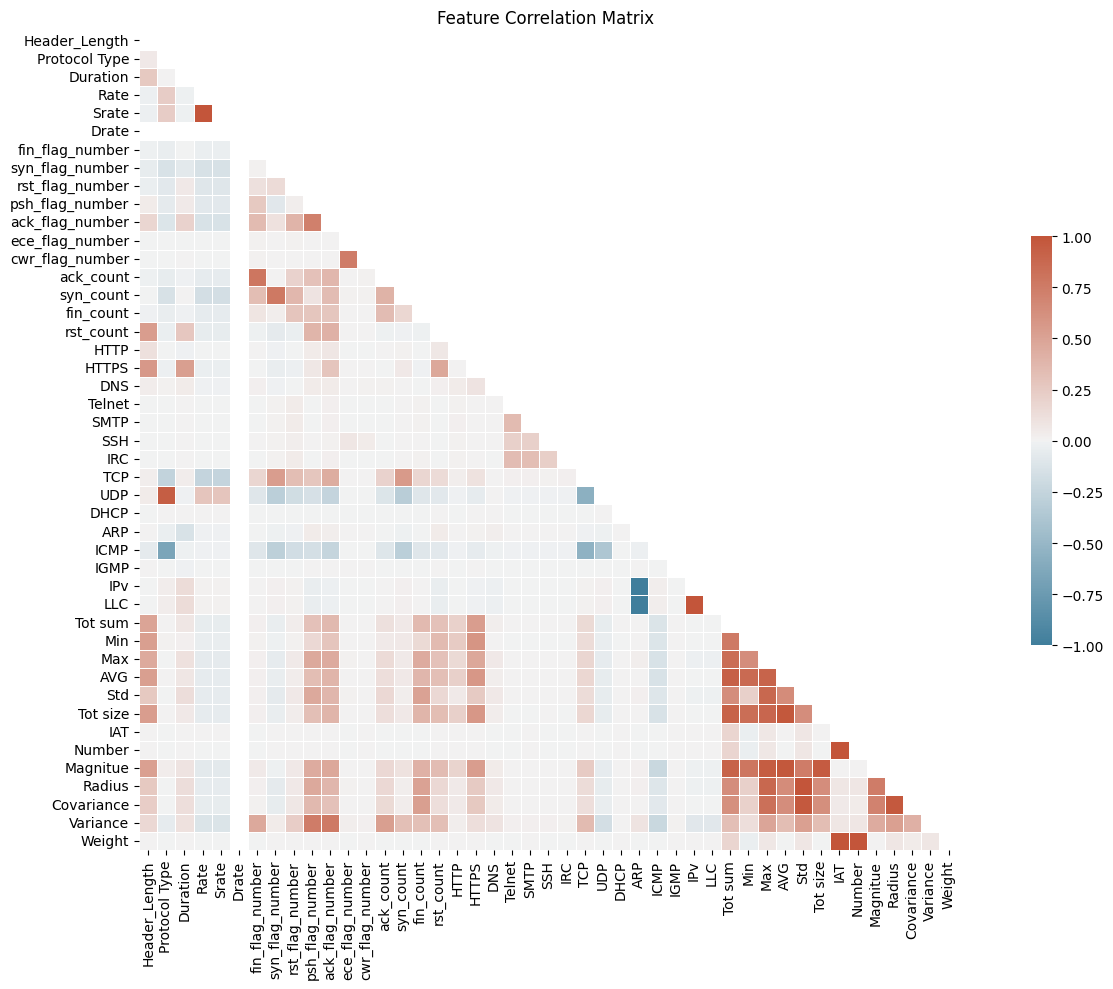


--- Top 10 High Variance Features ---
+---------------+--------------------+
| Feature       |           Variance |
+===============+====================+
| IAT           | 446844238910123.25 |
+---------------+--------------------+
| Header_Length |    174006034183.63 |
+---------------+--------------------+
| Srate         |      1429893748.19 |
+---------------+--------------------+
| Rate          |      1429893748.19 |
+---------------+--------------------+
| Covariance    |       898078009.60 |
+---------------+--------------------+
| Tot sum       |         1770394.19 |
+---------------+--------------------+
| rst_count     |          297672.03 |
+---------------+--------------------+
| Max           |           34281.01 |
+---------------+--------------------+
| AVG           |           14140.92 |
+---------------+--------------------+
| Tot size      |           14069.91 |
+---------------+--------------------+

--- Features with >90% correlation ---
+---------------+-------

In [23]:
def analyze_features(df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    # Correlation Analysis
    corr = df.corr(method = 'pearson')
    
    # Feature Variance
    variance = df.var().sort_values(ascending=False)
    
    # Zero Values Percentage
    zero_percent = (df == 0).sum() / len(df) * 100
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           xticklabels=True, yticklabels=True)
    plt.title('Feature Correlation Matrix ')
    plt.tight_layout()
    plt.savefig('img/correlation.png', bbox_inches='tight')
    plt.show()
    
    # Return analysis results
    analysis = {
        'correlation': corr,
        'variance': variance,
        'zero_percentage': zero_percent,
    }
    return analysis

def print_results(analysis_results)-> None:
    # Print variance
    print("\n--- Top 10 High Variance Features ---")
    variance_data = [[feature, value] for feature, value in 
                    analysis_results['variance'].head(10).items()]
    print(tabulate(variance_data, 
                headers=["Feature", "Variance"], 
                tablefmt="grid",
                floatfmt=".2f"))

    # Print correlations
    print("\n--- Features with >90% correlation ---")
    corr_matrix = analysis_results['correlation']
    high_corr = np.where(np.abs(corr_matrix) >= 0.9)
    high_corr_data = []
    for i, j in zip(*high_corr):
        if i < j:  # avoid duplicate pairs
            high_corr_data.append([
                corr_matrix.index[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ])
    print(tabulate(high_corr_data, 
                headers=["Feature 1", "Feature 2", "Correlation"], 
                tablefmt="grid",
                floatfmt=".3f"))

    # Print features with high zero percentage
    print("\n--- Top 10 Zero Value Percentages ---")
    zero_data = [[feature, value] for feature, value in 
                analysis_results['zero_percentage'].sort_values(ascending=False).head(10).items()]
    print(tabulate(zero_data, 
                headers=["Feature", "Zero %"], 
                tablefmt="grid",
                floatfmt=".5f"))

numeric_df = df.select_dtypes(include=[np.number])
analysis_results = analyze_features(numeric_df)
print_results(analysis_results)

## FEATURES SELECTION

We can see, both from the correlation matrix and from the percentages of zero values, that Drate column is emphty: we dropped it.

In [24]:
df=df.drop('Drate', axis=1)

This was the only trivial choice. However, further selection is needed: we can see that there's high correlation within our data, and this can hurt the quality of our models. For this reason, we want to keep only non-redundant feature to maximise the discriminatory power of our variables. 

We based our first approach on the simple observation of the output of the previous analysis. Through a combination of correlation and variance, we decided to drop the following columns: 

In [25]:
to_drop = ["Srate", "Protocol Type", "IPv", "LLC", "Tot sum", "Tot size", "AVG", "Max", "Number", "Weight"]
df_sel_manual = df.drop(columns=to_drop)

To begin evaluating our dataset and choices, we setup a first Classification model. We want to predict if a packet flow is benign or malicious using a Random Forest. For this, we created a new boolean column 'is_benign'. Since we have an abundance of data, we splitted the training dataset into Train and Validation sets, to avoid overfitting the test dataset in this feature selection phase.

In [30]:
# Creating a new boolean column 'is_benign'
df_sel_manual['is_benign'] = df['category'].apply(lambda x: 1 if x == 'BENIGN' else 0)

# Splitting the Dataset in Training and Validation sets
X_train, X_val, y_train, y_val = train_test_split(
    df_sel_manual.drop(['is_benign', 'category', 'attack'], axis=1),
    df_sel_manual['is_benign'], train_size=0.7
)

# Training the RandomForest
rnd_forest = RandomForestClassifier(random_state=42)
rnd_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

A useful metric that the RandomForest ensemble provides, is the Feature Importance (Gini index). This can be used for further refinement of our feature selection.

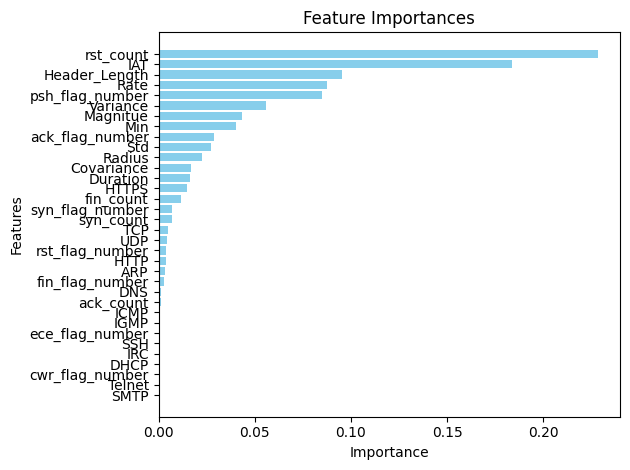

In [31]:
feature_importances_dict = dict(zip(X_train.columns, rnd_forest.feature_importances_))

# Sort features by importance
sorted_dict = dict(sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=False))

# Create plot
#plt.figure(figsize=(8,8))
plt.barh([*sorted_dict.keys()], sorted_dict.values(), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

Evaluating the performance on the validation set, using common metrics:

In [34]:
y_pred = rnd_forest.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy:        {accuracy:.5f}")
print(f"Precision:       {precision:.5f}")
print(f"Recall:          {recall:.5f}")
print(f"F1:              {f1:.5f}")

Accuracy:        0.99856
Precision:       0.97508
Recall:          0.96382
F1:              0.96942


The results are good, but let's try now selecting our features with an approach more robust and reliable. This time, over the correlation calculation (same as before), we compute a Hierarchical Clustering, to group the features more correlated between each others. We selected euclidean distance and complete linkage.

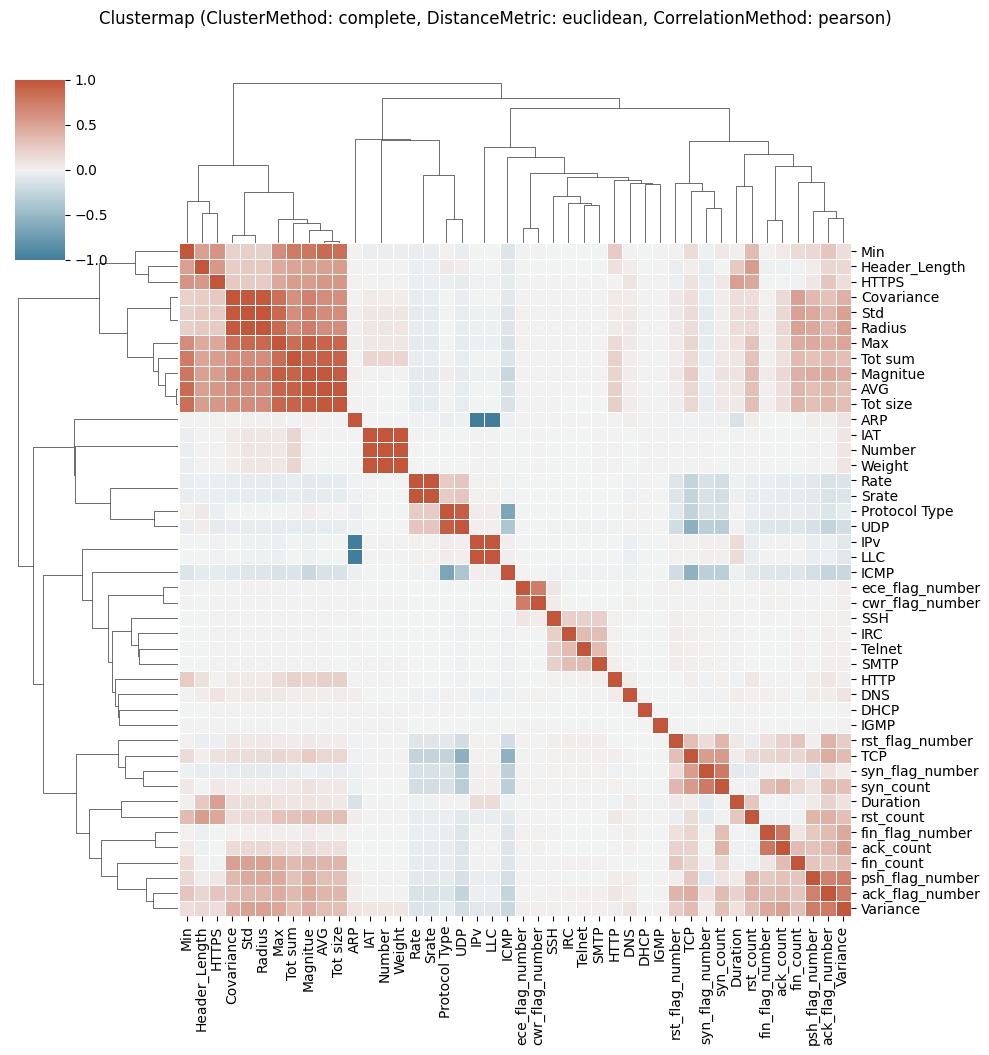

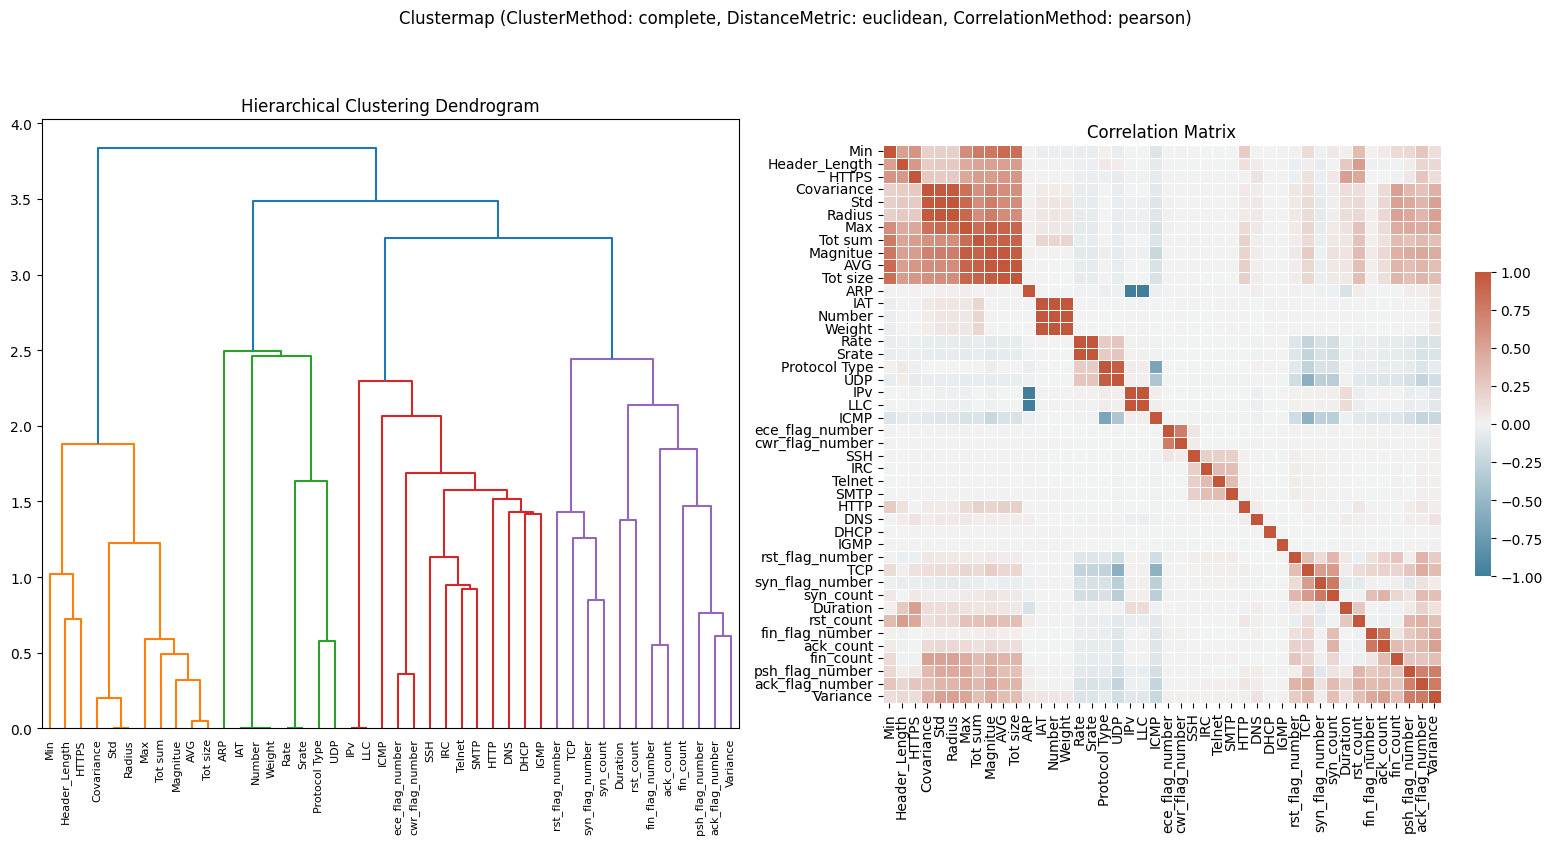

In [35]:
# Parameters
corr_method = 'pearson'
link_method = 'complete'
dist_metric = 'euclidean'

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Compute the correlation matrix (Pearson)
corr = df.drop(['is_benign', 'attack', 'category'], axis=1).corr(method=corr_method)

# Create the clustermap (but we will not display it directly)
g = sns.clustermap(corr, annot=False, cbar=True, cmap=cmap, center=0,
                   linewidths=.5, cbar_kws={"shrink": .5},
                   metric=dist_metric, method=link_method, xticklabels=True, yticklabels=True)
g.fig.suptitle(f"Clustermap (ClusterMethod: {link_method}, DistanceMetric: {dist_metric}, CorrelationMethod: {corr_method})", y=1.05)
plt.show()

# Extract the linkage matrix for the dendrogram
linkage_matrix = g.dendrogram_col.linkage

# Create a figure with two subplots: one for the dendrogram, one for the correlation matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot the dendrogram (left plot)
dendrogram(linkage_matrix, ax=ax1, labels=corr.columns)
ax1.set_title("Hierarchical Clustering Dendrogram")

# Reorder the correlation matrix based on the dendrogram leaf order
dendro_idx = g.dendrogram_col.reordered_ind
reordered_corr = corr.iloc[dendro_idx, dendro_idx]

# Plot the reordered correlation matrix (right plot)
sns.heatmap(reordered_corr, annot=False, cmap=cmap, cbar=True, ax=ax2, cbar_kws={"shrink": .5}, 
            linewidths=0.5, square=True, xticklabels=True, yticklabels=True)
ax2.set_title("Correlation Matrix")

# Add a title for the entire figure
fig.suptitle(f"Clustermap (ClusterMethod: {link_method}, DistanceMetric: {dist_metric}, CorrelationMethod: {corr_method})", y=1.05)

# Adjust layout
plt.tight_layout()
plt.show()

Our decision here is limited in choosing which distance threshold to pick by visually inpecting the dendrogram. The rest in done automatically by the script that selects the feature with the highest importance (Gini), one for each of the clusters resulting by the decided threshold.

In [36]:
# Set a threshold for the clustering
threshold = 1  # Adjust this value based on visual inspection of the dendrogram

# Cut the dendrogram at the chosen threshold to form clusters
clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')

# Let's group the features by their cluster assignment
clustered_features = {}
for idx, cluster in enumerate(clusters):
    if cluster not in clustered_features:
        clustered_features[cluster] = []
    clustered_features[cluster].append(corr.columns[idx])

# Print features for each cluster
print("Clustered features:")
for cluster, features in clustered_features.items():
    print(f"Cluster {cluster}: {features}")

# Train a RandomForest from the original dataset
X_train, X_val, y_train, y_val = train_test_split(df.drop(['is_benign', 'category', 'attack'], axis=1), df['is_benign'], train_size=0.7)
rnd_forest = RandomForestClassifier(random_state=42)
rnd_forest.fit(X_train, y_train)
# Extract feature importances
feature_importances = rnd_forest.feature_importances_
# Create a dictionary of feature importances
feature_importance_dict = dict(zip(X_train.columns, feature_importances))
# Sort the features by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Select the most important feature from each cluster based on feature importance
selected_features = []
for cluster, features in clustered_features.items():
    # Get the importance of each feature in the cluster
    cluster_importances = {feature: feature_importance_dict[feature] for feature in features}
    
    # Select the feature with the highest importance in the cluster
    best_feature = max(cluster_importances, key=cluster_importances.get)
    selected_features.append(best_feature)

# Print the selected features
print("\nSelected features for each cluster:")
for feature in selected_features:
    print(feature)

Clustered features:
Cluster 1: ['Header_Length', 'HTTPS']
Cluster 7: ['Protocol Type', 'UDP']
Cluster 21: ['Duration']
Cluster 6: ['Rate', 'Srate']
Cluster 23: ['fin_flag_number', 'ack_count']
Cluster 18: ['syn_flag_number', 'syn_count']
Cluster 20: ['rst_flag_number']
Cluster 24: ['psh_flag_number', 'ack_flag_number', 'Variance']
Cluster 10: ['ece_flag_number', 'cwr_flag_number']
Cluster 25: ['fin_count']
Cluster 22: ['rst_count']
Cluster 16: ['HTTP']
Cluster 15: ['DNS']
Cluster 11: ['Telnet', 'SMTP', 'IRC']
Cluster 12: ['SSH']
Cluster 19: ['TCP']
Cluster 13: ['DHCP']
Cluster 8: ['ARP']
Cluster 17: ['ICMP']
Cluster 14: ['IGMP']
Cluster 9: ['IPv', 'LLC']
Cluster 4: ['Tot sum', 'Max', 'AVG', 'Tot size', 'Magnitue']
Cluster 2: ['Min']
Cluster 3: ['Std', 'Radius', 'Covariance']
Cluster 5: ['IAT', 'Number', 'Weight']

 Selected features for each cluster:
Header_Length
Protocol Type
Duration
Srate
ack_count
syn_count
rst_flag_number
psh_flag_number
ece_flag_number
fin_count
rst_count
HTTP
D

In [38]:
selected_features.extend(['is_benign', 'attack', 'category'])
df_sel_hclust = df[selected_features]

Let's train a new RandomForest with the dataset containing the selected features

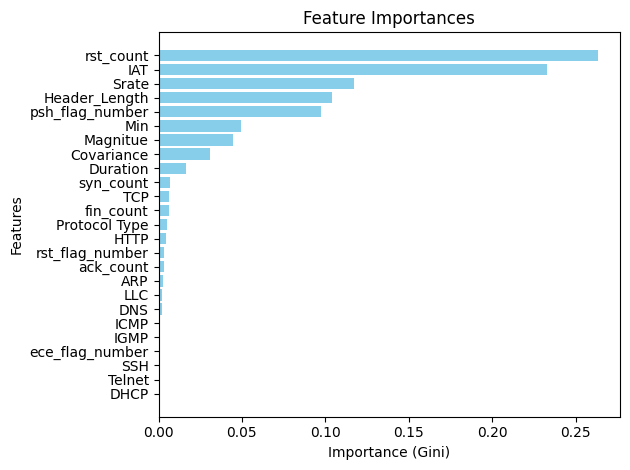

In [40]:
X_train, X_val, y_train, y_val = train_test_split(df_sel_hclust.drop(['is_benign', 'category', 'attack'], axis=1),
                                                  df_sel_hclust['is_benign'], train_size=0.7
                                                 )
rnd_forest.fit(X_train, y_train)
feature_importances_dict = dict(zip(X_train.columns, rnd_forest.feature_importances_))

# Sort features by importance
sorted_dict = dict(sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=False))

# Create plot
#plt.figure(figsize=(8,8))
plt.barh([*sorted_dict.keys()], sorted_dict.values(), color='skyblue')
plt.xlabel('Importance (Gini)')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

Let's test the performance of the new approach we used for feature selection

In [41]:
y_pred = rnd_forest.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy:        {accuracy:.5f}")
print(f"Precision:       {precision:.5f}")
print(f"Recall:          {recall:.5f}")
print(f"F1:              {f1:.5f}")

Accuracy:        0.99866
Precision:       0.97736
Recall:          0.96550
F1:              0.97139


There was an improvement!